# Electrode selecting

This notebook demonstrates a simple version of an electrode-selecting method defined in `chmap.probe_npx.select_weaker:electrode_select`, which is a [Neuropixels probe](https://www.neuropixels.org/) electrode-selecting method with a weaker arrangement rule.

## Terms

* `ChannelMap`: Neuropixels probe channel arrangement configuration (channel map).
* `ProbeDesp`: an interface for communicating between the chanelmap `ChannelMap` and the GUI.
* `ElectrodeDesp`: an interface for communicating between the electrode and the GUI, which contains category value.
* **category**: indicates how an electrode is selected. In here, we have density-based categories.
* **blueprint**: all electrode categories value (a collection). It decides how a channel map outcome.
* **hardware restriction rule**: a predicate representing whether electrodes can be selected together. Defined in `NpxProbeDesp.probe_rule`
* **arrangement rule**: a local density rule indicates how electrodes inside an area are selected to form a particular arrangement pattern by a given category.
* **probability**: each electrode has a probability value depending on its category value. It decides the probability of being selected.

## Introduction

predefined symbols

In [ ]:
M = ChannelMap
K = tuple[int, int, int] # (shank, column, row)

class E(ElectrodeDesp):
    electrode: K
    channel: int
    category: str
    prob: float # probability, but work as a priority here

### Hardware restriction rule

The hardware restriction rule of the Neuropixels probes is that the channel identifies used in the channel map are unique, which means electrodes used in the channel map can not share the same channel identifier.

The mapping between the electrode identification, and the channel identification is defined in `champ.probe_npx.npx:e2cb` and related functions. Users do not need to worry about how to use it, because `ElectrodeDesp` carried the channel information.

In [ ]:
# class NpxProbeDesp
def probe_rule(self, chmap: M | None, e1: E, e2: E) -> bool:
    return e1.channel != e2.channel

### Category

Each electrode has an category value that indicates how electrodes in an area are selected. The arrangement rule uses it.

We define basic categories in `ProbeDesp` and Neuropixels-specific categories in `NpxProbeDesp`:

* `CATE_UNSET`: initial category value. It works like **low-priority** with lower priority.
* `CATE_SET`: **pre-select** electrode are selected first.
* `CATE_FORBIDDEN`: **forbidden** electrodes are never selected. 
* `CATE_LOW`: **low-priority** electrodes are selected last. No arrangement pattern. Pick randomly.
* `CATE_FULL`: (Neuropixels-specific) **full-density** electrodes.
* `CATE_HALF`: (Neuropixels-specific) **half-density** electrodes.
* `CATE_QUARTER`: (Neuropixels-specific) **quarter-density** electrodes.

We use the bolded string to represent each category's value to demonstrate the purpose.

## Demostration

In [ ]:
def electrode_select(desp: ProbeDesp[M, E], chmap: M, blueprint: list[E], **kwargs) -> ChannelMap:
    """
    Selecting electrodes based on the electrode blueprint.

    :param desp:
    :param chmap: channelmap type. It is a reference.
    :param blueprint: channelmap blueprint
    :param kwargs: other parameters.
    :return: generated channelmap
    """
    step_1(...) # work as inlined function here
    step_2(...) # work as inlined function here
    step_loop(...) # work as inlined function here
    return build_channelmap()

### Idea

* For all electrodes, we initialize their probability value depending on their category value.
* We define a selected set `[e for e in blueprint if e.prob == 1]`, a forbidden set `[e for e in blueprint if e.prob == 0]`, and a candidate set.
* In each updating loop: we do
  * Select one electrode from the candidate set, and set its probability to 1, and set the probability to 0 for corresponding electrodes.
  * Update the neighbor candidate electrodes' probability by reducing their probability.
* Use the selected set to build the final channel map.

### Step 1: Initialization

Put all available electrodes into the candidate set `cand`. Initialize a probability value for all electrodes depending on their category value.


In [ ]:
def step_1(desp: ProbeDesp[M, E], chmap: M, blueprint: list[E]):
    # initialize a cancidate set
    cand: dict[K, E] = {
        it.electrode: E().copy(it, prob=0) for it in desp.all_electrodes(chmap)
    }
    # pass category value
    for e in blueprint:
        cand[e.electrode].category = e.category
    # initialize probability value
    for e in cand.values():
        e.prob = category_mapping_probability(e.category)

Here `category_mapping_probability` defined as

In [1]:
def category_mapping_probability(category: str) -> float:
    match category:
        case 'pre-selected':
            return 1.0
        case 'full-density':
            return 0.9
        case 'half-density':
            return 0.8
        case 'quarter-density':
            return 0.7
        case 'remainder':
            return 0.6
        case 'forbidden':
            return 0
        case _:
            return 0.5

### Step 2: Pre-Selection

Make the priority value of `pre-selected` electrodes to 1, and `forbidden` electrodes to 0, as well as all electrodes that against the hardware restriction rule.


In [ ]:
def step_2(desp: ProbeDesp[M, E], cand: dict[K, E]):
    for e in cand.values():
        if e.category == 'pre-selected':
            _add(desp, cand, e)

where a helper function `_add` defined as

In [ ]:
def _add(desp: ProbeDesp[M, E], cand: dict[K, E], e: E):
    e.prob = 1.0

    for k in cand.values():
        if e.electrode != k.electrode and not desp.probe_rule(None, e, k):
            k.prob = 0

### Step Loop: 

Start from this step, we enter a selecting loop.

In [ ]:
def step_loop(desp: ProbeDesp[M, E], chmap:M, cand: dict[K, E]):
    while selected_electrode(cand) < chmap.n_channels:
        if (e := pick_electrode(cand)) is not None:
            # step 4
            select_electrode(desp, cand, e)
            # step 5
            update_prob(desp, cand, e)
        else:
            break

where `selected_electrode` used as a terminated condiction.

In [ ]:
def selected_electrode(cond: dict[K, E]) -> int:
    # selected electrode is defined as it.prob == 1
    return len([it for it in cond.values() if it.prob == 1])

### Step 3: Select electrode

Randomly select an electrode with the highest priority value from the candidate set

In [ ]:
import random

def pick_electrode(cand: dict[K, E]) -> E | None:
    hp = max([it.prob for it in cand.values() if it.prob < 1])

    if hp == 0: # all un-selected electrode are forbidden
        return None

    sub = [it for it in cand.values() if hp <= it.prob < 1]
    assert len(sub) > 0
    return random.choice(sub)

### step 4: Add to channel map & Apply Hardware Rule

Set the priority of the selected electrode to 1, and set the priority of electrodes against the hardware restriction rule with the selected electrode to 0.


In [ ]:
def select_electrode(desp: ProbeDesp[M, E], cand: dict[K, E], e: E):
    _add(desp, cand, e)

### Step 5: Apply Arrangement Rule

Reduce the priority value of electrodes surrounded with the selected electrode with respect to its category.

In [ ]:
def update_prob(desp: NpxProbeDesp, chmap: M, cand: dict[K, E], e: E):
    for t in surr(cand, e):
        if t is not None and t.prob < 1:
            t.prob /= 2.0

where

In [ ]:
def surr(cand: dict[K, E], e: E) -> Iterator[E | None]:
    match e.category:
        case 'half-density':
            yield _get(cand, e, c=1,  r=0) # get an electrode move 1 column and 0 rows from the electrode e
            yield _get(cand, e, c=-1, r=0)
            yield _get(cand, e, c=0,  r=1)
            yield _get(cand, e, c=0,  r=-1)
        case 'quarter-density':
            # only works for 2-column probe
            yield _get(cand, e, c=-1, r=0)
            yield _get(cand, e, c=1,  r=0)
            yield _get(cand, e, c=-1, r=-1)
            yield _get(cand, e, c=0,  r=-1)
            yield _get(cand, e, c=1,  r=-1)
            yield _get(cand, e, c=-1, r=1)
            yield _get(cand, e, c=0,  r=1)
            yield _get(cand, e, c=1,  r=1)
            yield _get(cand, e, c=0,  r=2)
            yield _get(cand, e, c=0,  r=-2)
        case _:
            return

def _get(cand: dict[K, E], e: E, c: int, r: int) -> E | None:
    eh, ec, er = e.electrode
    return cand.get((eh, ec + c, er + r), None)

### Build the channelmap

build a channel

In [ ]:
def build_channelmap(desp: NpxProbeDesp, chmap: ChannelMap, cand: dict[K, E]) -> ChannelMap:
    ret = desp.new_channelmap(chmap)

    for e in cand.values():
        if e.prob == 1:
            desp.add_electrode(ret, e, overwrite=True)

    return ret

### control functions

Here we use information entropy as a control function to measure each update iteration.
Although the selection method will be terminated without the control function, we can still demonstrate how a control function works.

In [ ]:
import math

def information_entropy(cand: dict[K, E]) -> float:
    return -sum([it.prob * math.log2(it.prob) for it in cand.values() if it.prob > 0])

## Results

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from chmap.probe_npx import *
from chmap.probe_npx import plot
from chmap.probe_npx.desp import NpxProbeDesp

rc = matplotlib.rc_params_from_file('channelmap.matplotlibrc', fail_on_error=True, use_default_template=True)

D = NpxProbeDesp()
C = ChannelMap.from_imro('Fig3_example.imro')
Q = D.load_blueprint('Fig3_example.blueprint.npy', C)


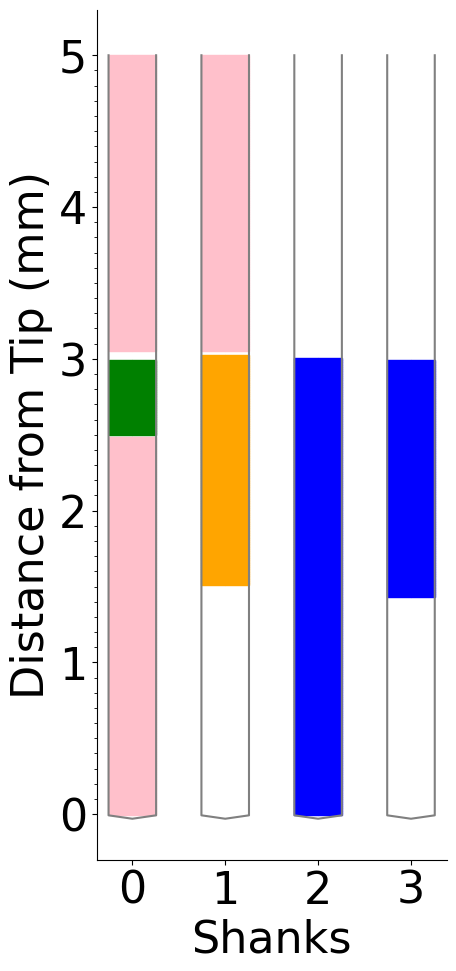

In [5]:
# blueprint

# TODO label color
with plt.rc_context(rc):
    fg, ax = plt.subplots()

    height = 5
    plot.plot_category_area(ax, C.probe_type, Q, height=height, shank_width_scale=2)
    plot.plot_probe_shape(ax, C.probe_type, height=height, color='gray', label_axis=True, shank_width_scale=2)


plt.show()

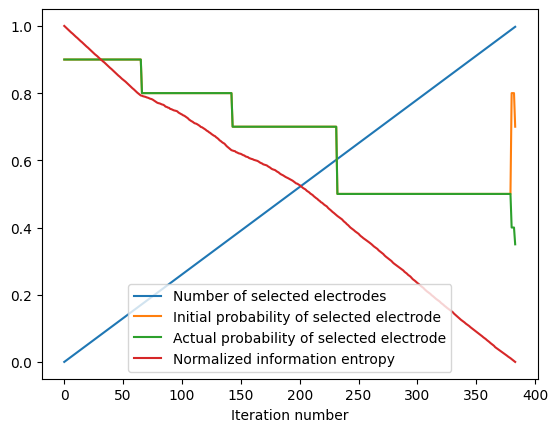

In [8]:
from chmap.probe_npx.select_weaker_debug import electrode_select
# select_weaker_debug inject debugging function into origin selecting method.
# so we can visualize the process

R = electrode_select(D, C, Q)
# shows measured value during the selection process
plt.show() # TODO label units
# N: number of selected electrodes / total channels
# Q: selected electrode's initial priority value
# P: selected electrode's actual priority value
# H: normalized information entropy value

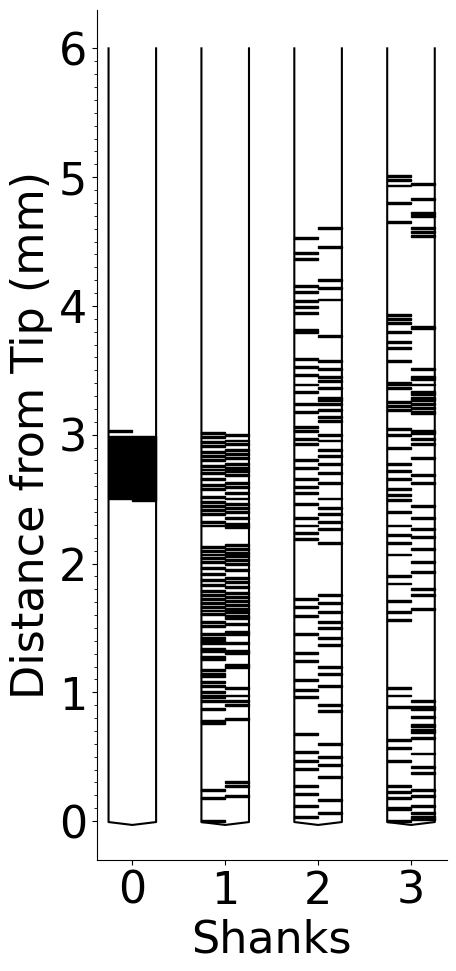

In [7]:
with plt.rc_context(rc):
    fg, ax = plt.subplots()
    plot.plot_channelmap_block(ax, R, height=6, color='k', shank_width_scale=2)
    plot.plot_probe_shape(ax, R, height=6, color='k', label_axis=True, shank_width_scale=2)

plt.show()

## Compare to the default selection

1. The default selection uses a *stronger* local density rule that updates the probability value to 0 for neighbor electrodes of the selected electrode equivalently. The weaker rule just decreases the value.
2. Those electrodes will never be selected in the future. Once it removes too many electrodes, the selections may produce an incomplete channel map. 
3. The weaker rule doesn't remove them from the candidate set, so they can be selected, which means the weaker rule always produces a complete channelmap (100% completed rate).
4. The actual electrode density in the final channel map produced by the default selection method could only be lower than the category setting. For that produced by the weaker rule, except the conflicts area, the actual electrode density may be higher than the category setting.